# graph LR-cifar-harris-图像尺寸还是32*32
A[SIFT特征提取] --> B[K-Means生成视觉词汇]
B --> C[图像编码为词袋直方图]
C --> D[SVM训练与分类]

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import sklearn
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.svm import SVC
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score  # 新增召回率和精确率
from tqdm import tqdm
import joblib

In [2]:
#====================================================
#            Load Dataset(CIFAR10)
#TYPE: airplane、automobile、bird、cat、deer、dog、frog、horse、ship、truck
#====================================================
from tensorflow.keras.datasets import cifar10

# 加载数据并展平标签
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.ravel()
y_test = y_test.ravel()

# 强制转换为 uint8 类型（确保数据未被意外修改）
X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)  # 新增此行

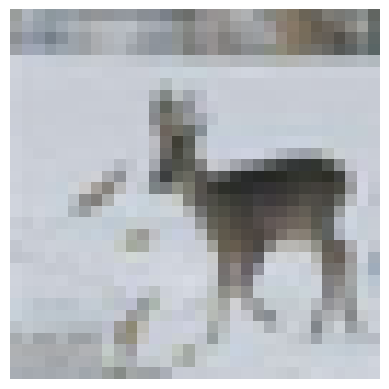

In [3]:
#====================================================
#            Data preprocessing(CIFAR10)
#====================================================

def resize_image(image_array, size=(32, 32)):
    # 输入 image_array 是 Keras 返回的 32x32x3 RGB 图像
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)  # 转 OpenCV 的 BGR 格式
    image_resized = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
    return image_resized

def resize_and_reshape_image(image_array, size=(32, 32)):
    # 强制转换为 uint8 类型
    if image_array.dtype != np.uint8:
        image_array = image_array.astype(np.uint8)
    
    # 转换颜色空间：Keras 的 RGB -> OpenCV 的 BGR
    image = cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)
    
    
    # 调整大小
    image_resized = cv2.resize(image, size, interpolation=cv2.INTER_CUBIC) #高质量插值方式（INTER_CUBIC）修改方法， INTER_CUBIC 是基于4x4像素邻域的双三次插值，比 INTER_LINEAR 更保留边缘结构，对角点检测更友好。有用！！
    
    return image_resized

# show image
sample_image = resize_and_reshape_image(X_train[20])
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))  # BGR转RGB
plt.axis('off')
plt.show()

In [4]:
#====================================================
#            Harris corner detection----Harris检测可以替换成别的检测方式，但是SIFT 的描述子还是保持不变，后续添加。
# 考虑后续非极大值抑制（non-maximum suppression）的处理，目前会出现很多的圈圈
#====================================================
import cv2
import numpy as np

def detect_harris_keypoints(
    img,
    max_points=200,
    block_size=3,
    ksize=5,
    k=0.04,
    threshold_ratio=0.05,
    min_dist=10
):
    """
    使用 Harris + goodFeaturesToTrack 提取关键点
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(
        gray,
        maxCorners=max_points,
        qualityLevel=threshold_ratio,
        minDistance=min_dist,
        blockSize=block_size,
        useHarrisDetector=True,
        k=k
    )
    keypoints = []
    if corners is not None:
        for c in corners:
            x, y = c.ravel()
            # <-- 这里传第三个位置参数 size
            keypoints.append(cv2.KeyPoint(x, y, ksize*2))
    return keypoints

#====================================================
#            SIFT自带的关键点检测器
#====================================================

def detect_sift_keypoints(img):
    sift = cv2.SIFT_create()
    kps, _ = sift.detectAndCompute(img, None)
    return kps

#====================================================
#            ORB检测器
#====================================================

def detect_orb_keypoints(img, max_keypoints=500):
    """
    使用 ORB 检测关键点（不使用 ORB 描述子，只使用关键点）
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(nfeatures=max_keypoints)
    keypoints = orb.detect(gray, None)
    return keypoints

#====================================================
#            FAST检测器
#====================================================

def detect_fast_keypoints(img, threshold=10, nonmax=True):
    """
    使用 FAST 检测关键点（不使用描述子）
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fast = cv2.FastFeatureDetector_create(threshold=threshold, nonmaxSuppression=nonmax)
    keypoints = fast.detect(gray, None)
    return keypoints

#====================================================
#            计算SIFT描述子
#====================================================

def compute_sift_descriptors(img, keypoints):
    """
    在指定关键点上计算SIFT描述子
    Args:
        img: BGR格式的输入图像
        keypoints: KeyPoint对象列表
    Returns:
        descriptors: 描述子矩阵 (N×128)，若无关键点则返回None
    """
    if len(keypoints) == 0:
        return None
    
    # 初始化SIFT（仅计算描述子，不检测关键点）
    sift = cv2.SIFT_create()
    
    # 计算描述子
    _, descriptors = sift.compute(img, keypoints)
    return descriptors


In [5]:
#====================================================
#      Data preprocessing and feature extraction
#====================================================

def extract_features(images, max_samples=None):
    """
    从CIFAR-10图像中提取Harris+SIFT特征
    Args:
        images: 原始CIFAR-10图像数据（N×3072）
        max_samples: 最大采样数量（用于调试）
    Returns:
        all_descriptors: 所有有效描述子组成的列表
        valid_indices: 有效图像的索引（排除无关键点的图像）
    """
    all_descriptors = []
    valid_indices = []
    
    # 控制采样数量（调试用）
    if max_samples is not None:
        images = images[:max_samples]
    
    for idx, img_array in enumerate(images):
        # 转换为OpenCV BGR图像
        img = resize_and_reshape_image(img_array)
        
        # sift自带检测关键点
        #keypoints = detect_sift_keypoints(img)
        
        # Harris检测关键点
        keypoints = detect_harris_keypoints(img)
        
        # ORB检测关键点
        #keypoints = detect_orb_keypoints(img)
        
        # FAST检测关键点
        #keypoints = detect_fast_keypoints(img)
        
        # 计算SIFT描述子
        descriptors = compute_sift_descriptors(img, keypoints)
        
        if descriptors is not None:
            all_descriptors.extend(descriptors)
            valid_indices.append(idx)
    
    return np.array(all_descriptors), valid_indices

# 提取训练集特征
train_descriptors, train_valid_idx = extract_features(X_train, max_samples=50000)
print(f"提取到 {len(train_descriptors)} 个描述子，有效图像 {len(train_valid_idx)} 张")

# 过滤无效图像（无关键点的图像）
filtered_train_images = X_train[train_valid_idx]
filtered_train_labels = y_train[train_valid_idx]

提取到 198994 个描述子，有效图像 49994 张


In [6]:
#====================================================
#      词袋模型构建
#====================================================

from sklearn.cluster import MiniBatchKMeans

def build_codebook(descriptors, k=64):
    """
    构建视觉词汇（Codebook）
    Args:
        descriptors: 所有描述子组成的矩阵 (N×128)
        k: 聚类中心数量
    Returns:
        kmeans: 训练好的K-Means模型
    """
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=42)
    kmeans.fit(descriptors)
    return kmeans

# 生成Codebook（示例k=64）
codebook = build_codebook(train_descriptors, k=256) #有用，k值改大一点

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

def encode_bow_features(images, codebook):
    """
    将图像编码为BoW直方图
    Args:
        images: 原始图像数据（N×3072）
        codebook: 训练好的K-Means模型
    Returns:
        X: BoW特征矩阵 (N×k)
    """
    X = []
    for img_flat in images:
        img = resize_and_reshape_image(img_flat)
        keypoints = detect_harris_keypoints(img)
        descriptors = compute_sift_descriptors(img, keypoints)
        
        if descriptors is None:
            hist = np.zeros(codebook.n_clusters)
        else:
            labels = codebook.predict(descriptors)
            hist = np.bincount(labels, minlength=codebook.n_clusters)
            hist = hist / hist.sum()  # 归一化
        
        X.append(hist)
    
    return np.array(X)




In [8]:
# 编码训练集和测试集
X_train = encode_bow_features(filtered_train_images, codebook)
y_train = filtered_train_labels

# 测试集同理（需先过滤无效图像）
test_descriptors, test_valid_idx = extract_features(X_test)
filtered_test_images = X_test[test_valid_idx]
filtered_test_labels = y_test[test_valid_idx]
X_test = encode_bow_features(filtered_test_images, codebook)
y_test = filtered_test_labels

#TF-IDF 处理有用！！
tfidf = TfidfTransformer(norm='l2')  # 默认就是 L2 归一化
X_train_tfidf = tfidf.fit_transform(X_train).toarray()  # 用训练集拟合
X_test_tfidf = tfidf.transform(X_test).toarray()        # 用相同模型变换测试集


# 特征标准化（非常重要，应该在 SVM 训练前进行）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tfidf)  # 使用训练数据进行拟合
X_test_scaled = scaler.transform(X_test_tfidf)  # 使用相同的标准化方式转换测试数据

In [9]:
# 设置参数网格
'''
param_grid = {
    'C': [0.1,1,5,10],
    'kernel': ['linear','rbf'],
    'gamma': ['scale', 'auto']
}
'''

param_grid = {
    'C': [1],
    'kernel': ['rbf'],
    'gamma': ['scale']
}


param_list = list(ParameterGrid(param_grid))

# 初始化
best_model = None
best_score = 0
best_f1 = 0
best_params = None

# Grid Search 带进度条
with tqdm(total=len(param_list), desc="Grid Search Progress", ncols=100) as pbar:
    for params in param_list:
        model = SVC(**params, probability=True)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
         # 打印当前参数组合的性能
        print(f"参数组合: {params} | Accuracy: {acc:.4f} | Weighted F1: {f1:.4f}")
        

        # 保存当前最优模型
        if acc > best_score:
            best_score = acc
            best_f1 = f1
            best_model = model
            best_params = params

            joblib.dump(best_model, "sift_bow_best_svm_cifar0504_harris-4.1.joblib")
            joblib.dump(codebook, "sift_bow_codebook_cifar0504_harris-4.1.joblib")
            joblib.dump(scaler, "sift_bow_scaler_cifar0504_harris-4.1.joblib")

        pbar.update(1)

# 输出最终最优结果
print("\n✅ 最优模型参数:", best_params)
print(f"最佳准确率: {best_score:.4f}")
print(f"最佳 F1 分数: {best_f1:.4f}")

Grid Search Progress: 100%|█████████████████████████████████████████| 1/1 [57:57<00:00, 3477.18s/it]

参数组合: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'} | Accuracy: 0.3183 | Weighted F1: 0.3135

✅ 最优模型参数: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
最佳准确率: 0.3183
最佳 F1 分数: 0.3135


In [10]:
def enhanced_model_evaluation_svm(model, X_test, y_test, class_names):
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
    import matplotlib.pyplot as plt
    import seaborn as sns

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')
    weighted_f1 = f1_score(y_test, y_pred, average='weighted')
    macro_precision = precision_score(y_test, y_pred, average='macro')
    weighted_precision = precision_score(y_test, y_pred, average='weighted')
    macro_recall = recall_score(y_test, y_pred, average='macro')
    weighted_recall = recall_score(y_test, y_pred, average='weighted')

    print(f'\n{" Enhanced Evaluation ":-^50}')
    print(f'Accuracy:           {acc:.4f}')
    print(f'Macro F1:           {macro_f1:.4f}')
    print(f'Weighted F1:        {weighted_f1:.4f}')
    print(f'Macro Precision:    {macro_precision:.4f}')
    print(f'Weighted Precision: {weighted_precision:.4f}')
    print(f'Macro Recall:       {macro_recall:.4f}')
    print(f'Weighted Recall:    {weighted_recall:.4f}')

    print(f'\n{" Classification Report ":-^50}')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


-------------- Enhanced Evaluation ---------------
Accuracy:           0.3183
Macro F1:           0.3135
Weighted F1:        0.3135
Macro Precision:    0.3129
Weighted Precision: 0.3129
Macro Recall:       0.3183
Weighted Recall:    0.3183

------------- Classification Report --------------
              precision    recall  f1-score   support

    airplane     0.3406    0.2970    0.3173      1000
  automobile     0.3324    0.3710    0.3507      1000
        bird     0.2892    0.2820    0.2856      1000
         cat     0.2608    0.2050    0.2296      1000
        deer     0.2633    0.2330    0.2472      1000
         dog     0.3036    0.3270    0.3149      1000
        frog     0.2701    0.3030    0.2856      1000
       horse     0.2874    0.2170    0.2473      1000
        ship     0.4452    0.5570    0.4949      1000
       truck     0.3368    0.3910    0.3619      1000

    accuracy                         0.3183     10000
   macro avg     0.3129    0.3183    0.3135     10000
wei

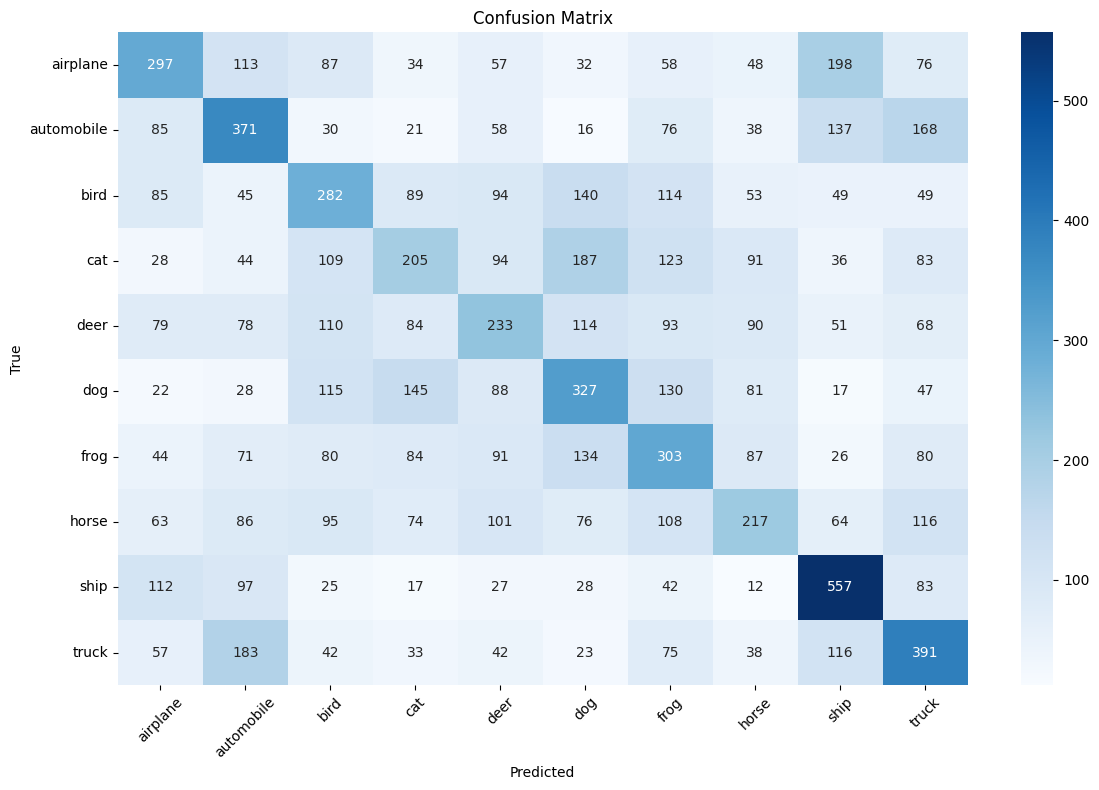

In [11]:
# 加载你上面保存的模型
from joblib import load

best_model = load("sift_bow_best_svm_cifar0504_harris-4.1.joblib")
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
enhanced_model_evaluation_svm(best_model, X_test_scaled, y_test, class_names)

In [12]:
def predict_local_image_sift(image_path, kmeans, svm, class_names):
    """
    参数说明：
    - image_path: 本地图像路径（支持jpg/png等格式）
    - kmeans: 训练好的KMeans模型（用于BoW特征编码）
    - svm: 训练好的SVM分类器（用于最终预测）
    - class_names: 类别名称列表
    """
    try:
        # 1. 读取原始图像
        image = cv2.imread(image_path)
        #image = cv2.resize(image_ori, (32, 32))
        
        if image is None:
            raise FileNotFoundError(f"无法读取文件：{image_path}")

        # 2. 图像灰度转换 + SIFT特征提取
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sift = cv2.SIFT_create()
        kp, des = sift.detectAndCompute(gray, None)

        if des is None:
            raise ValueError("无法从图像中提取SIFT特征")

        # 3. 特征编码为BoW直方图
        words = kmeans.predict(des)
        histogram = np.zeros(kmeans.n_clusters)
        for w in words:
            histogram[w] += 1
        histogram = histogram.reshape(1, -1)
        #print("BoW 直方图（未标准化）:", histogram)
        histogram = scaler.transform(histogram)  # 标准化特征
        #print("BoW 直方图（已标准化）:", histogram)

        # 4. SVM预测类别
        predicted_label = svm.predict(histogram)[0]
        probs = svm.predict_proba(histogram)[0]  # 获取所有类别的概率
        #print(f"Prediction probabilities: {probs}")
        
        # 找到最大概率的类别索引
        max_prob_index = np.argmax(probs)
        predicted_class = class_names[max_prob_index]
        confidence = probs[max_prob_index]
        
        # 打印预测类别及置信度
        print(f"Predicted Class: {predicted_class} with Confidence: {confidence:.2%}")
        
        print("SIFT 关键点数量:", len(kp))

        # 5. 可视化结果
        plt.figure(figsize=(15, 6))
        
        # 左侧：绘制SIFT关键点图
        plt.subplot(1, 2, 1)
    
        key_img = cv2.drawKeypoints(
            image, kp, None, 
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # 显示方向和大小的圆圈
        )
        plt.imshow(cv2.cvtColor(key_img, cv2.COLOR_BGR2RGB))
        plt.title(f"SIFT Keypoints (Detected: {len(kp)})")
        plt.axis('off')

        # 右侧：绘制类别置信度直方图
        plt.subplot(1, 2, 2)
        bar_colors = ['skyblue'] * len(class_names)  # 设定天蓝色
        bar_colors[max_prob_index] = 'red'  # 将最大概率的类别设为红色
        plt.barh(class_names, probs, color=bar_colors)
        plt.title(f"Prediction: {predicted_class} ({confidence:.2%})")
        plt.xlabel("Confidence")
        plt.gca().invert_yaxis()  # 反转y轴标签的顺序
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()

        return class_names[predicted_label], probs[predicted_label]

    except Exception as e:
        print(f"预测出错：{str(e)}")
        return None, None

Predicted Class: cat with Confidence: 19.80%
SIFT 关键点数量: 433


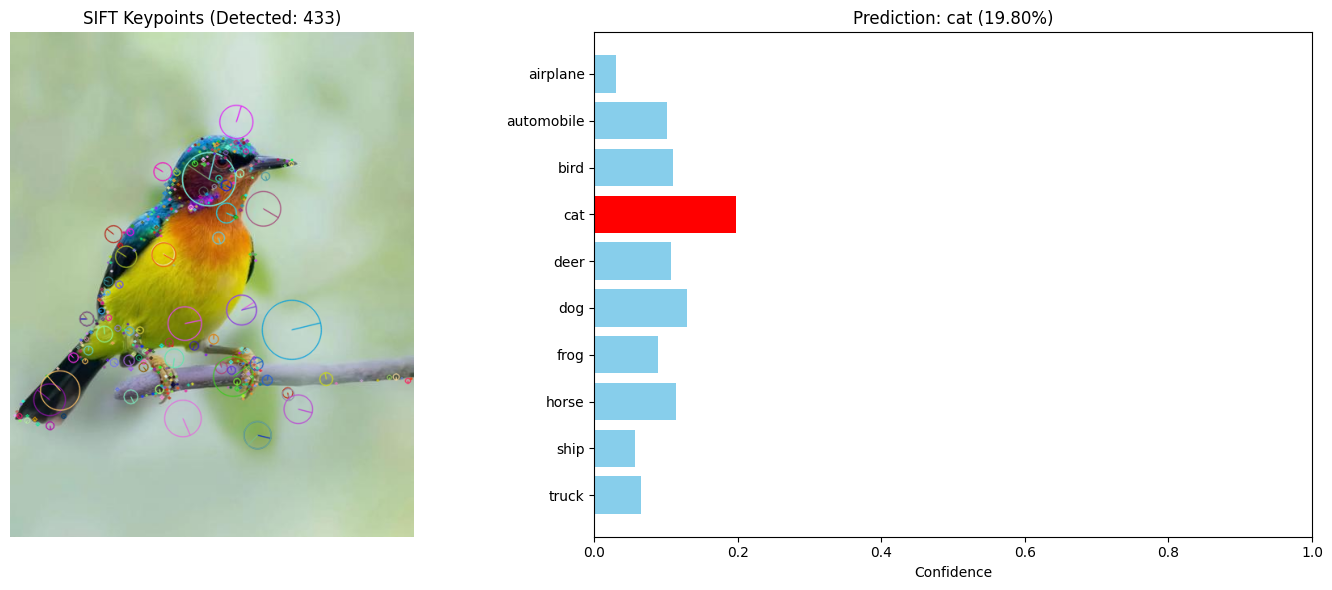

In [13]:
# ====================================================
#               Test Example for SIFT
# ====================================================
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

img_path = "dataset/testImg/bird.jpeg"

pred_class, confidence = predict_local_image_sift(
    image_path=img_path,
    kmeans=codebook,   # 训练好的KMeans模型
    svm=best_model,         # 训练好的SVM模型
    class_names=class_names
)
